**Overview**
<pre>
The data has been split into two groups:

training set (train.csv)
test set (test.csv)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

Data Dictionary
Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
</pre>

**Variable Notes**
<pre>
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.
</pre>

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

pd.options.display.max_columns = None

In [191]:
left = 0.5  # the left side of the subplots of the figure
right = 0.9   # the right side of the subplots of the figure
bottom = 0.4  # the bottom of the subplots of the figure
top = 0.5     # the top of the subplots of the figure
wspace = 0.8  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.8  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
    
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

<Figure size 432x288 with 0 Axes>

In [108]:
ds = pd.read_csv("./data/titanic/train.csv")
ds.set_index('PassengerId', inplace=True)
ds.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [109]:
ds.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Cabin feature contains a lot of null values. In addition to it, I feel that this variable does not play much role in prediction.
I don't think Titanic crew asked for people's cabin number before allocating them to a life boat. And same goes with PClass variable

In [110]:
# Drop cabin variable
ds = ds.drop(['Cabin'], axis=1)
ds = ds.drop(['Pclass'], axis=1)

[]

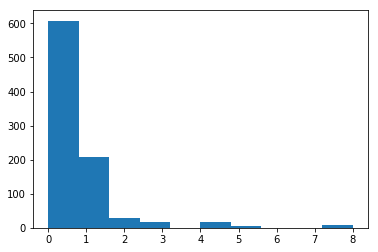

In [111]:
plt.hist(ds.SibSp)
plt.plot()

Seems most of the people were travelling either alone or with there spouse

[]

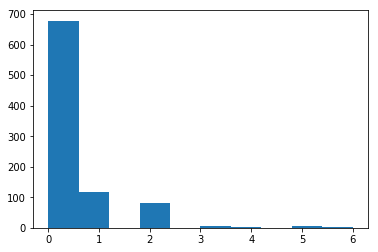

In [201]:
plt.hist(ds.Parch)
plt.plot()

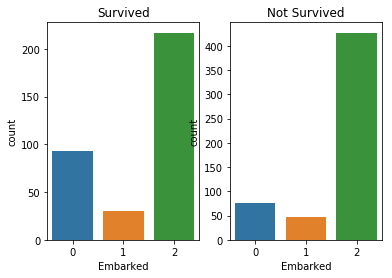

In [112]:
plt.subplot(121)
plt.title("Survived")
sns.countplot(x='Embarked', data=tempds[tempds.Survived==1])
plt.subplot(122)
plt.title("Not Survived")
sns.countplot(x='Embarked', data=tempds[tempds.Survived==0])
plt.show()

Seems People people from all Embarkation have almost equal proportion in Survival and Dying.
Lets do a Chi-Sqaured test to look more into it

In [113]:
def chisqaure_test(df, col1, col2):
    groupSize = df.groupby([col1, col2]).size()
    groupSum = groupSize.unstack(col1)
    #Filling null values to 0 to prevent code to not throw any exceptions
    groupSum = groupSum.fillna(0)
    return chi2_contingency(groupSum)

Assuming significance level as 5%, meaning I am assuming Confidence level of 95% to check if 2 categorical values have any relationship? 

In [114]:
chisqaure_test(tempds, 'Survived', 'Embarked')

(26.48914983923762,
 1.769922284120912e-06,
 2,
 array([[103.7480315,  64.2519685],
        [ 47.5511811,  29.4488189],
        [397.7007874, 246.2992126]]))

Here p-value < significance level, hence I have evidence to proove that there is some relationship between Survived and Embarked

In [135]:
tempds.columns

Index(['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [131]:
tempds = ds
tempds = tempds.dropna(subset=['Embarked'], axis=0)

In [134]:
names = tempds['Name']
tempds = tempds.drop(['Name', 'Ticket'], axis=1)

In [156]:
tempds.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,0,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,1,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,0,male,35.0,0,0,8.0500,S


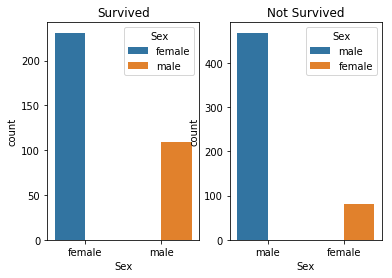

In [188]:
plt.subplot(121)
plt.title("Survived")
sns.countplot(x='Sex', data=tempds[tempds.Survived==1], hue='Sex')
plt.subplot(122)
plt.title("Not Survived")
sns.countplot(x='Sex', data=tempds[tempds.Survived==0], hue='Sex')
plt.show()

Seems that Titanic crew members saved more Women than Men

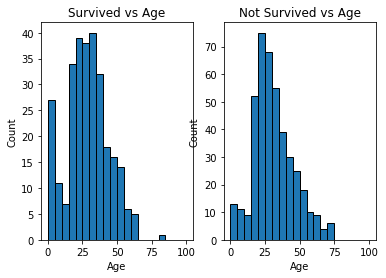

In [181]:
survived_ages = tempds[tempds.Survived == 1]
nsurvived_ages = tempds[tempds.Survived == 0]

plt.subplot(121)
hist, edges = np.histogram(survived_ages.Age, bins=np.arange(0,101,5))
plt.bar(edges[:-1], hist, align="edge", ec="k", width=np.diff(edges))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Survived vs Age")

plt.subplot(122)
hist, edges = np.histogram(nsurvived_ages.Age, bins=np.arange(0,101,5))
plt.bar(edges[:-1], hist, align="edge", ec="k", width=np.diff(edges))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Not Survived vs Age")

plt.show()

They tried to save as many child (below age 5) as possible 

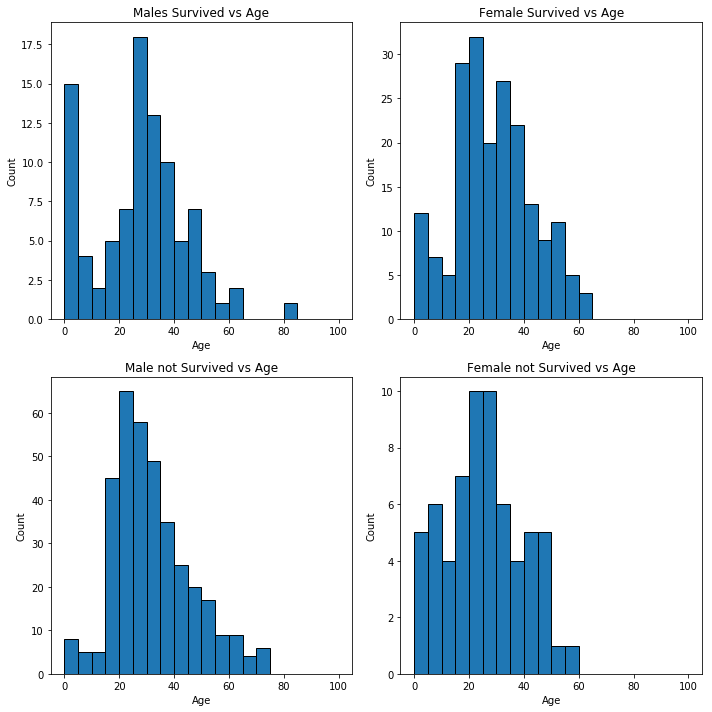

In [200]:
m_surv_age = survived_ages[survived_ages.Sex == 'male']
f_surv_age = survived_ages[survived_ages.Sex == 'female']

m_nsurv_age = nsurvived_ages[nsurvived_ages.Sex == 'male']
f_nsurv_age = nsurvived_ages[nsurvived_ages.Sex == 'female']

fig, axis = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(10)

plt.subplot(221)
hist, edges = np.histogram(m_surv_age.Age, bins=np.arange(0,101,5))
plt.bar(edges[:-1], hist, align="edge", ec="k", width=np.diff(edges))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Males Survived vs Age")

plt.subplot(222)
hist, edges = np.histogram(f_surv_age.Age, bins=np.arange(0,101,5))
plt.bar(edges[:-1], hist, align="edge", ec="k", width=np.diff(edges))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Female Survived vs Age")

plt.subplot(223)
hist, edges = np.histogram(m_nsurv_age.Age, bins=np.arange(0,101,5))
plt.bar(edges[:-1], hist, align="edge", ec="k", width=np.diff(edges))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Male not Survived vs Age")

plt.subplot(224)
hist, edges = np.histogram(f_nsurv_age.Age, bins=np.arange(0,101,5))
plt.bar(edges[:-1], hist, align="edge", ec="k", width=np.diff(edges))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Female not Survived vs Age")

fig.tight_layout()

plt.show()

Graph suggests that most new born male babies were the priority over teenage or men in their 20s and 30s 

In [202]:
X = tempds.iloc[:, 1:]
y = tempds.iloc[:, 0]

In [204]:
X.head()

,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,
1,male,22.0,1,0,7.2500,S
2,female,38.0,1,0,71.2833,C
3,female,26.0,0,0,7.9250,S
4,female,35.0,1,0,53.1000,S
5,male,35.0,0,0,8.0500,S


In [207]:
X_copy = X

In [258]:
tempds.corr()

,Sex,Age,SibSp,Parch,Fare,category_C,category_Q,category_S
Sex,1.000000,0.070209,-0.116348,-0.247508,-0.179958,-0.084520,-0.075217,0.121405
Age,0.070209,1.000000,-0.084150,-0.163495,-0.063801,0.033664,0.289715,-0.211872
SibSp,-0.116348,-0.084150,1.000000,0.414542,0.160887,-0.060074,-0.026692,0.069438
Parch,-0.247508,-0.163495,0.414542,1.000000,0.217532,-0.011588,-0.081585,0.061512
Fare,-0.179958,-0.063801,0.160887,0.217532,1.000000,0.270731,-0.116684,-0.163758
category_C,-0.084520,0.033664,-0.060074,-0.011588,0.270731,1.000000,-0.148646,-0.782613
category_Q,-0.075217,0.289715,-0.026692,-0.081585,-0.116684,-0.148646,1.000000,-0.499261
category_S,0.121405,-0.211872,0.069438,0.061512,-0.163758,-0.782613,-0.499261,1.000000


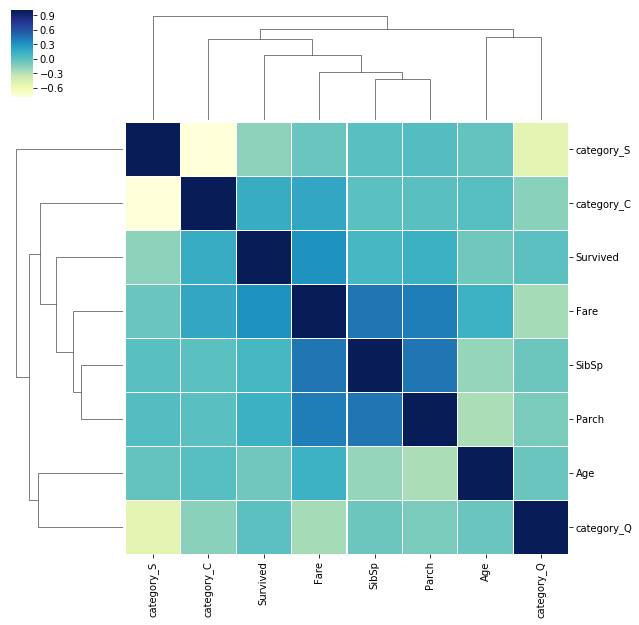

In [259]:
corrmat = tempds.corr(method='spearman')
cg = sns.clustermap(corrmat, cmap="YlGnBu", linewidths=0.1);
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cg

In [213]:
gender_encoder = LabelEncoder()
X.iloc[:,0] = gender_encoder.fit_transform(X.iloc[:,0])
X.head()

,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,
1,1,28,1,0,7.2500,S
2,0,51,1,0,71.2833,C
3,0,34,0,0,7.9250,S
4,0,47,1,0,53.1000,S
5,1,47,0,0,8.0500,S


In [155]:
tempds.iloc[:, 0] = gender_encoder.inverse_transform(tempds.iloc[:, 0])

In [237]:
# One hot encoding the Embarked variable
embarked = X.iloc[:,-1]
embarked.head()

PassengerId
1    S
2    C
3    S
4    S
5    S
Name: Embarked, dtype: object

In [241]:
X['Embarked_n'] = pd.Categorical(X['Embarked'])

In [239]:
#Convert to dummies
dummy_df = pd.get_dummies(X['Embarked_n'], prefix='category')
dummy_df.head()

,category_C,category_Q,category_S
PassengerId,,,
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1
5,0,0,1


In [243]:
X = X.drop(['Embarked_n'], axis=1)
X = X.drop(['Embarked'], axis=1)

In [245]:
X = pd.concat([X, dummy_df], axis=1)
X.head()

,Sex,Age,SibSp,Parch,Fare,category_C,category_Q,category_S
PassengerId,,,,,,,,
1,1,28,1,0,7.2500,0,0,1
2,0,51,1,0,71.2833,1,0,0
3,0,34,0,0,7.9250,0,0,1
4,0,47,1,0,53.1000,0,0,1
5,1,47,0,0,8.0500,0,0,1


In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

711


In [249]:
# Headers for classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [250]:
MNBClassifier = MultinomialNB()
MNBClassifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [255]:
y_predict = MNBClassifier.predict(X_test)
accuracy_score(y_predict, y_test)

0.7078651685393258

In [256]:
from sklearn.naive_bayes import GaussianNB
GNBClassifier = GaussianNB()
GNBClassifier.fit(X_train, y_train)
y_predict1 = GNBClassifier.predict(X_test)
accuracy_score(y_predict1, y_test)

0.7640449438202247

# For Kaggle Submission

In [261]:
testds = pd.read_csv("./data/titanic/test.csv")
testds.set_index('PassengerId', inplace=True)
testds.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [262]:
# Drop cabin variable
testds = testds.drop(['Cabin'], axis=1)
testds = testds.drop(['Pclass'], axis=1)

testds = testds.dropna(subset=['Embarked'], axis=0)

names = testds['Name']
testds = testds.drop(['Name', 'Ticket'], axis=1)

In [267]:
# One hot encoding the Embarked variable
embarked = X.iloc[:,-1]
embarked.head()

testds['Embarked_n'] = pd.Categorical(testds['Embarked'])
#Convert to dummies
dummy_df = pd.get_dummies(testds['Embarked_n'], prefix='category')
dummy_df.head()

testds = testds.drop(['Embarked_n'], axis=1)
testds = testds.drop(['Embarked'], axis=1)

testds = pd.concat([testds, dummy_df], axis=1)
testds.head()

,Sex,Age,SibSp,Parch,Fare,category_C,category_Q,category_S
PassengerId,,,,,,,,
892,male,34.5,0,0,7.8292,0,1,0
893,female,47.0,1,0,7.0000,0,0,1
894,male,62.0,0,0,9.6875,0,1,0
895,male,27.0,0,0,8.6625,0,0,1
896,female,22.0,1,1,12.2875,0,0,1


In [268]:
testds.iloc[:,0] = gender_encoder.fit_transform(testds.iloc[:,0])

In [276]:
testds = testds.dropna(subset=['Fare'], axis=0)

In [279]:
testds.isnull().sum()

Sex            0
Age           86
SibSp          0
Parch          0
Fare           0
category_C     0
category_Q     0
category_S     0
dtype: int64

In [286]:
testds.dtypes

Sex             int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
category_C      uint8
category_Q      uint8
category_S      uint8
dtype: object

In [287]:
testds['Fare'].unique()

array([  7.8292,   7.    ,   9.6875,   8.6625,  12.2875,   9.225 ,
         7.6292,  29.    ,   7.2292,  24.15  ,   7.8958,  26.    ,
        82.2667,  61.175 ,  27.7208,  12.35  ,   7.225 ,   7.925 ,
        59.4   ,   3.1708,  31.6833,  61.3792, 262.375 ,  14.5   ,
        61.9792,  30.5   ,  21.6792,  31.5   ,  20.575 ,  23.45  ,
        57.75  ,   8.05  ,   9.5   ,  56.4958,  13.4167,  26.55  ,
         7.85  ,  13.    ,  52.5542,  29.7   ,   7.75  ,  76.2917,
        15.9   ,  60.    ,  15.0333,  23.    , 263.    ,  15.5792,
        29.125 ,   7.65  ,  16.1   ,  13.5   ,   7.725 ,  21.    ,
         7.8792,  42.4   ,  28.5375, 211.5   ,  25.7   ,  15.2458,
       221.7792,  10.7083,  14.4542,  13.9   ,   7.775 ,  52.    ,
         7.7958,  78.85  ,   7.8542,  55.4417,   8.5167,  22.525 ,
         7.8208,   8.7125,  15.0458,   7.7792,  31.6792,   7.2833,
         6.4375,  16.7   ,  75.2417,  15.75  ,   7.25  ,  23.25  ,
        28.5   ,  25.4667,  46.9   , 151.55  ,  18.    ,  51.8

In [277]:
#Prediction with Multinomial NB
y_predict = MNBClassifier.predict(testds)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

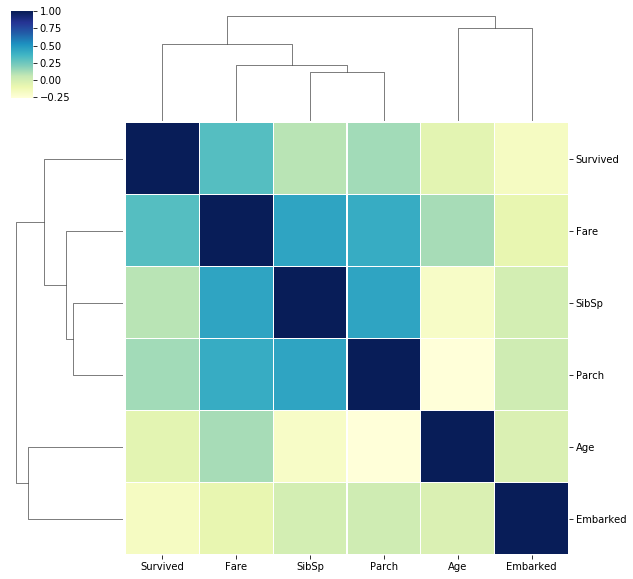

In [35]:
ds.dropna?

In [24]:
nullData = pd.isnull(ds.Age)
ds[nullData]
# ds['Age'].unique()
# ds['Age'].dtype

,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
6,0,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q
18,1,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,S
20,1,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,C
27,0,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,C
29,1,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,Q
30,0,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,S
32,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,C
33,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,Q
37,1,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,C


,Sex,Age,SibSp,Parch,Fare,category_C,category_Q,category_S
Sex,1.000000,0.070209,-0.116348,-0.247508,-0.179958,-0.084520,-0.075217,0.121405
Age,0.070209,1.000000,-0.084150,-0.163495,-0.063801,0.033664,0.289715,-0.211872
SibSp,-0.116348,-0.084150,1.000000,0.414542,0.160887,-0.060074,-0.026692,0.069438
Parch,-0.247508,-0.163495,0.414542,1.000000,0.217532,-0.011588,-0.081585,0.061512
Fare,-0.179958,-0.063801,0.160887,0.217532,1.000000,0.270731,-0.116684,-0.163758
category_C,-0.084520,0.033664,-0.060074,-0.011588,0.270731,1.000000,-0.148646,-0.782613
category_Q,-0.075217,0.289715,-0.026692,-0.081585,-0.116684,-0.148646,1.000000,-0.499261
category_S,0.121405,-0.211872,0.069438,0.061512,-0.163758,-0.782613,-0.499261,1.000000


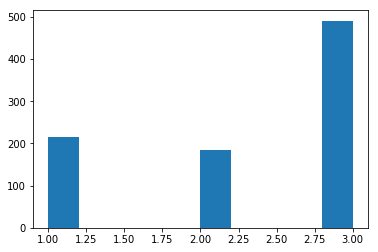

In [19]:
plt.hist(ds.Pclass)
plt.show()